In [1]:
!pip install wget
import os
import torch
import pandas as pd
import numpy as np
import torch
from torch import nn


ssh_config = """
Host github.com
  IdentityFile ~/.ssh/github.pem
  User davipeag
  StrictHostKeyChecking no
"""

if os.name == 'nt':
  base_path = ""
  REPO_DIR = "."
  STORE_DIR ="." 
  print("Windows")
else:
  print("Unix-like")
  REPO_DIR = "/tmp/HeartRateRegression"
  from google.colab import drive
  drive.mount('/content/drive')
  GIT_PATH = "/content/drive/My\ Drive/deeplearning_project/github.pem"
  DATA_DIR = os.path.join(REPO_DIR, "repo")
  STORE_DIR ="/content/drive/My Drive/deeplearning_project/" 
  !mkdir ~/.ssh
  !cp -u {GIT_PATH} ~/.ssh/
  !chmod u=rw,g=,o= ~/.ssh/github.pem
  !echo "{ssh_config}" > ~/.ssh/config
  !chmod u=rw,g=,o= ~/.ssh/config
  ! (cd /tmp && git clone git@github.com:davipeag/HeartRateRegression.git)
  ! (cd {REPO_DIR} && git pull )
  import sys
  sys.path.append(REPO_DIR)

def git_pull():
  ! (cd {REPO_DIR} && git pull )

git_pull()


Unix-like
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.ssh’: File exists
fatal: destination path 'HeartRateRegression' already exists and is not an empty directory.
Already up to date.
Already up to date.


In [2]:
import random
import torch
from torch import nn
import numpy as np
args = {
    'epoch_num': 250,     # Number of epochs.
    'lr': 1.0e-3,           # Learning rate.
    'weight_decay': 10e-4, # L2 penalty.
    'momentum': 0.9,      # Momentum.
    'num_workers': 0,     # Number of workers on data loader.
    'batch_size': 128,     # Mini-batch size. 128
    'batch_test': 248,     # size of test batch
    'window': 15,
    'initial_window':5,
    'clip_norm': 6.0,     # Upper limit on gradient L2 norm ###
}
if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

SEED = 1234
def reset_seeds(seed=SEED):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

reset_seeds(SEED)

cuda


In [3]:
from data_utils import (PpgDaliaExtractor, FormatPPGDalia)

extractor = PpgDaliaExtractor(DATA_DIR)
ppg_dalia_formatter = FormatPPGDalia()
dfs_train_dalia = [ppg_dalia_formatter.transform(extractor.extract_subject(i)) for i in range(1,16)]
[len(df)//32 for df in dfs_train_dalia]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """


[9206,
 8199,
 8735,
 9144,
 9299,
 5244,
 9337,
 8074,
 8554,
 10642,
 9042,
 7908,
 9130,
 8952,
 7933]

In [4]:
from data_utils import (Pamap2Handler, FormatPamap)

SUBJECTS = list(range(1,9))

handler = Pamap2Handler(DATA_DIR)
formatter = FormatPamap()
dfs_train_pamap2 = [formatter.transform(handler.get_protocol_subject(i)) for i in SUBJECTS]
[len(df)//200 for df in dfs_train_pamap2]

[1882, 2235, 1264, 1647, 1873, 1809, 1567, 2040]

In [5]:
git_pull()

import importlib

import PPG
import preprocessing_utils
from PPG import FullTrainer
import RegressionHR

from RegressionHR import FullTrainer
from RegressionHR import PceLstmDefaults
from RegressionHR import PceLstmModel
from RegressionHR import TrainerJoint
from RegressionHR import  UtilitiesData
from RegressionHR import FullTrainer2

import Trainer
from  Trainer import BatchTrainers
from Trainer import BatchComputers
from Trainer import Interfaces


importlib.reload(PPG.AttentionDefaults)
importlib.reload(PPG)
importlib.reload(PPG.UtilitiesDataXY)
importlib.reload(PPG.Models)
importlib.reload(PPG.NoHrPceLstmModel)
importlib.reload(PPG.TrainerXY)
importlib.reload(PPG.TrainerIS)
importlib.reload(PPG.FullTrainer)
importlib.reload(PceLstmDefaults)
importlib.reload(preprocessing_utils)
importlib.reload(RegressionHR)
importlib.reload(RegressionHR.FullTrainer)
importlib.reload(RegressionHR.FullTrainer2)
importlib.reload(RegressionHR.PceLstmDefaults)
importlib.reload(PPG.UtilitiesDataXY)
importlib.reload(preprocessing_utils)
importlib.reload(RegressionHR.TrainerJoint)
importlib.reload(RegressionHR.UtilitiesData)
importlib.reload(RegressionHR.PceLstmModel)

importlib.reload(preprocessing_utils)
importlib.reload(Trainer)
importlib.reload(Trainer.BatchTrainers)
importlib.reload(Trainer.BatchComputers)
importlib.reload(Trainer.ToolBox)
importlib.reload(Trainer.Interfaces )

Already up to date.


<module 'Trainer.Interfaces' from '/tmp/HeartRateRegression/Trainer/Interfaces.py'>

In [6]:
import matplotlib.pyplot as plt
import pickle

def compute_ensemble(results):
  
  ys = [v["predictions"][0].reshape(-1).numpy() for v in results]
  min_len_y = min([len(y) for y in ys])
  ys = [y[:min_len_y] for y in ys]
  for i in range(1, len(ys)-1):
    # assert np.all(ys[i] == ys[i-1])
    assert np.all(np.abs(ys[i] - ys[i-1])<1)
  ps = np.stack([v["predictions"][1].reshape(-1).numpy()[:min_len_y] for v in results])

  s = ps[0]
  for p in ps[1:]:
    s = s + p

  a = s/len(ps)
  y = ys[0]

  plt.figure()
  plt.plot(a)
  plt.plot(y)
  plt.show()

  return np.mean(np.abs(a - y)), np.mean(np.abs(ps - y))


def compute_ensemble_named(results, model_name="PceLstm"):
  
  results = [r[model_name] for r in results]

  ys = [v["labels"].reshape(-1) for v in results]
  min_len_y = min([len(y) for y in ys])
  ys = [y[:min_len_y] for y in ys]
  for i in range(1, len(ys)-1):
    # assert np.all(ys[i] == ys[i-1])
    assert np.all(np.abs(ys[i] - ys[i-1])<1)
  ps = np.stack([v["predictions"].reshape(-1)[:min_len_y] for v in results])

  s = ps[0]
  for p in ps[1:]:
    s = s + p

  a = s/len(ps)
  y = ys[0]

  plt.figure()
  plt.plot(a)
  plt.plot(y)
  plt.show()

  return np.mean(np.abs(a - y)), np.mean(np.abs(ps - y))

# compute_ensemble_named(aresults[0].values())

ts_per_is: 12
sample_per_ts: 400
ts_per_is: 12
sample_per_ts: 128
best val epoch: 1
[1/100]: loss_train: [18.788048, 28.06131, 0.9979252986558375, 0.9889197945675632] loss_val [25.096199, 26.952827, 0.9999999981425145, 0.997965571764748] loss_ts [18.094278, 16.272348, 1.0000000004709504, 0.9999999996010992]
best val epoch: 2
[2/100]: loss_train: [17.875738, 21.018728, 0.994890327707165, 1.0559810325713543] loss_val [23.664186, 21.560938, 0.9999999979774047, 0.9933297919560443] loss_ts [17.351072, 21.711079, 1.0000000001177376, 1.0000000006027834]
best val epoch: 3
[3/100]: loss_train: [16.320402, 23.163824, 0.9951140501417194, 1.0710253662109608] loss_val [20.765343, 21.684946, 1.000000000742994, 1.0099624083607344] loss_ts [16.597586, 21.930092, 1.0000000011479413, 1.0003247646828763]
best val epoch: 4
[4/100]: loss_train: [15.593159, 19.442327, 0.9956351797189886, 1.0750712838505732] loss_val [20.721012, 19.949778, 0.999999999545948, 1.01113608624877] loss_ts [15.3572035, 19.31769, 0

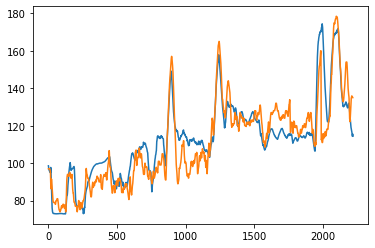

1-TS:(7.757077, 7.757077)
ts_per_is: 12
sample_per_ts: 400
ts_per_is: 12
sample_per_ts: 128
best val epoch: 1
[1/100]: loss_train: [20.071037, 19.47849, 0.9947755769412746, 1.0036143600494445] loss_val [18.442719, 20.501522, 0.824962826081987, 1.000000000105632] loss_ts [26.557352, 13.718834, 1.0, 0.9941687019280165]
best val epoch: 4
[4/100]: loss_train: [20.284971, 18.977526, 0.9936193336921063, 1.0310760233244056] loss_val [18.28668, 18.801413, 0.8216064744270765, 1.0000000008802672] loss_ts [20.537659, 12.930615, 1.0000000031742118, 1.013088758134337]
best val epoch: 5
[5/100]: loss_train: [19.723621, 17.005224, 0.9938268391521109, 1.0386826137514111] loss_val [17.64329, 16.656088, 0.8229546184546849, 0.9999999990070587] loss_ts [20.890125, 12.074593, 1.0002427089672823, 1.0426316545152468]
best val epoch: 6
[6/100]: loss_train: [17.87148, 16.88877, 0.9957130453698971, 1.0071333248084153] loss_val [16.029692, 16.024523, 0.8224164257211798, 0.9999999991267751] loss_ts [20.334099, 12

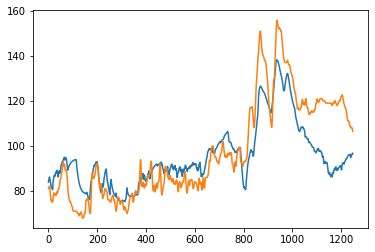

2-TS:(9.841741, 9.841741)
ts_per_is: 12
sample_per_ts: 400
ts_per_is: 12
sample_per_ts: 128
best val epoch: 1
[1/100]: loss_train: [21.463324, 25.529173, 0.9989189896431131, 1.001433898765956] loss_val [21.505293, 22.52215, 1.00000000016511, 0.9999999998028202] loss_ts [14.777305, 16.955725, 0.9815177438563443, 0.9999999987253733]
best val epoch: 2
[2/100]: loss_train: [20.686867, 20.694632, 0.9979291139715204, 0.9777922013050152] loss_val [20.707209, 21.511839, 0.9999999992982833, 0.9999999998239466] loss_ts [13.605672, 14.197869, 1.0002151887497845, 1.000000000309854]
best val epoch: 3
[3/100]: loss_train: [18.786488, 19.798344, 0.9946932097793371, 0.9995669437371867] loss_val [18.858574, 19.461487, 0.9999999995872254, 0.9999999997323988] loss_ts [14.545076, 11.840174, 0.9809609041835761, 0.9999999996619774]
best val epoch: 4
[4/100]: loss_train: [14.716907, 19.245375, 0.9901827409698726, 1.029941994706557] loss_val [14.100287, 17.708977, 0.9999999988029538, 1.0000000001760534] loss_

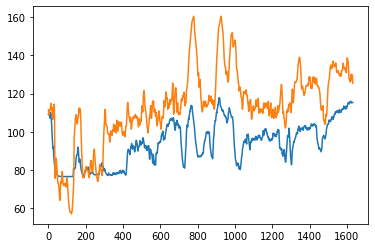

3-TS:(20.038208, 20.038208)
ts_per_is: 12
sample_per_ts: 400
ts_per_is: 12
sample_per_ts: 128
best val epoch: 2
[2/100]: loss_train: [19.308191, 17.6618, 0.9994203839845691, 1.0115106504623934] loss_val [22.60259, 16.558212, 0.9999999993808382, 1.0000000010140677] loss_ts [18.827805, 34.635075, 0.999999997275688, 1.000000000826981]
best val epoch: 3
[3/100]: loss_train: [17.60483, 15.268231, 0.9983187827226719, 1.0182083716273256] loss_val [21.03472, 14.220208, 0.9999999997523352, 1.0000000005070337] loss_ts [17.135786, 44.03608, 0.9999999994221156, 0.9999999998070378]
best val epoch: 4
[4/100]: loss_train: [16.500343, 14.4302635, 1.0017662001190308, 0.9994975746748322] loss_val [19.852943, 14.5632515, 0.9999999990093411, 1.0000000014084274] loss_ts [16.013401, 38.172523, 0.9999999998348902, 0.9999999999173019]
best val epoch: 5
[5/100]: loss_train: [16.073109, 14.541539, 1.005497046215853, 1.019907290366569] loss_val [18.459454, 14.152556, 1.0008529301660543, 1.0000172192142793] loss_

In [ ]:
fchoice = {
    'is_h_size': 64,
    'ts_per_is': 12,
    'period_s': 4,
    'step_s': 2,
    'alpha': 0.90,
    'ts_per_sample': 50,
    'batch_size': 64,
    'weight_decay': 1e-05,
    'lr': 0.005,
    'dropout_rate': 0.15,
    'lstm_input': 128,
    'lstm_size': 64,
    'ts_h_size': 16,
    'alpha': 0.9,
    'margin': 1,
}

discriminator_false_label = 0
from RegressionHR import FullTrainer2
import Trainer.BatchTrainers
from PPG import UtilitiesDataXY
from collections import defaultdict
import torch 

nepoch = 100
aresults_pamap2 = defaultdict(dict)
aresults_dalia = defaultdict(dict)
pamap2_size = 8
dalia_size = 15
for val_sub in range(min(pamap2_size, dalia_size)):
  for ts_sub1 in range(pamap2_size):
    if val_sub == ts_sub1:
      continue
    val_sub1 = val_sub
    val_sub2 = val_sub
    ts_sub2 = ts_sub1
    full_trainer = FullTrainer2.PceLstmTripletDiscriminatorPamap2DaliaJointTraining(
        dfs_ds1 = dfs_train_pamap2,
        dfs_ds2 = dfs_train_dalia,
        device = args["device"],
        nepoch = nepoch,
        ts_sub1 = ts_sub1,
        ts_sub2 = ts_sub2,
        val_sub1 = val_sub1,
        val_sub2 = val_sub2,
        main_index = 0
        )
    filename = f"pamap_ts_{ts_sub1}_val_{val_sub1}_dalia_ts_{ts_sub2}_val_{val_sub2}_alpha_{fchoice['alpha']}_lr_{fchoice['lr']}-joint_val_nepoch_{nepoch}_triplet.pkl"
    save_path = os.path.join(STORE_DIR, filename)
    try:
      with open(save_path , "rb") as f:
        out = pickle.load(f)
    except FileNotFoundError:
      out = full_trainer.train(**fchoice)
      with open(save_path, "wb") as f:
        pickle.dump(out, f)    
    print(out["args"], [out[k]['metric'] for k in (full_trainer.lstm_name1,  full_trainer.lstm_name2, full_trainer.discriminator_name1, full_trainer.discriminator_name2)])
    aresults_pamap2[ts_sub1][val_sub1] = out
    print(f"{ts_sub1}-TS:{compute_ensemble_named(list(aresults_pamap2[ts_sub1].values()), full_trainer.lstm_name1)}")
  for ts_sub2 in range(dalia_size):
    if val_sub == ts_sub2:
      continue
    val_sub1 = val_sub
    val_sub2 = val_sub
    ts_sub1 = ts_sub2 % pamap2_size
    filename = f"dalia_ts_{ts_sub2}_val_{val_sub2}_pamap2_ts_{ts_sub1}_val_{val_sub1}_alpha_{fchoice['alpha']}_lr_{fchoice['lr']}-joint_val_nepoch_{nepoch}_triplet.pkl"
    save_path = os.path.join(STORE_DIR, filename)
    try:
      with open(save_path , "rb") as f:
        out = pickle.load(f)
    except FileNotFoundError:
      full_trainer = FullTrainer2.PceLstmTripletDiscriminatorPamap2DaliaJointTraining(
        dfs_ds1 = dfs_train_pamap2,
        dfs_ds2 = dfs_train_dalia,
        device = args["device"],
        nepoch = nepoch,
        ts_sub1 = ts_sub1,
        ts_sub2 = ts_sub2,
        val_sub1 = val_sub1,
        val_sub2 = val_sub2,
        main_index = 1
        )
      out = full_trainer.train(**fchoice)
      with open(save_path, "wb") as f:
          pickle.dump(out, f)
    print(out["args"], [out[k]['metric'] for k in (full_trainer.lstm_name1,  full_trainer.lstm_name2, full_trainer.discriminator_name1, full_trainer.discriminator_name2)])
    aresults_dalia[ts_sub2][val_sub2] = out
    print(f"{ts_sub2}-TS:{compute_ensemble_named(list(aresults_dalia[ts_sub1].values()), full_trainer.lstm_name2)}")

In [ ]:
# filename = f"pamap_ts_{1}_val_{0}_dalia_ts_{1}_val_{0}_alpha_{fchoice['alpha']}_lr_{fchoice['lr']}-joint_val_nepoch_{nepoch}_triplet.pkl"
# save_path = os.path.join(STORE_DIR, filename)

# !ls '{save_path}'

In [ ]:
def compute_metric_mean(values, k):
  return np.mean([v[k]['metric'] for v in values])

ms = dict()

for k,values in aresults.items():
  vals = list(aresults[k].values())
  e, m = compute_ensemble_named(vals)
  t = compute_metric_mean(vals, 'PceDiscriminator')
  print(f"{k}: {e} {m} {t}")
  ms[k] = (e, m, t)

print()
for k,v in ms.items():
  print(k, v)

